## Exploring the MPC's Isolated Tracklet File
#### Matthew J. Holman


12 November 2017

I am using this notebook as a starting point for the cs182 final project to link the ITF.

The plan is to:

    * Get the ITF records into a reasonable format, with the observatory locations determined, the time converted to jd_utc, jd_ut1, and jd_tdb, and the RA/Dec converted to unit vectors.
    * We need to keep the original format lines around, for later orbit fitting.
    * Separate the tracklets into months between successive full moons.
    * Determine the healpix region for each tracklet
    * Transform the tracklets in each time/healpix block into a local projection
    * Do the linear fit for each tracklet to get the a, b, g, adot, bdot solutions
    * Look for clusters in those solutions

### The NOVAS package

First, get the USNO's python NOVAS package.  We'll need that.

http://aa.usno.navy.mil/software/novas/novas_py/novaspy_intro.php

Just type 

pip install novas

pip install novas_de405

Here's the reference:

Barron, E. G., Kaplan, G. H., Bangert, J., Bartlett, J. L., Puatua, W., Harris, W., & Barrett, P. (2011) “Naval Observatory Vector Astrometry Software (NOVAS) Version 3.1, Introducing a Python Edition,” Bull. AAS, 43, 2011.

### The kepcart library

You will need to make sure you have a copy of the kepcart library.  There is a copy of it on the MPC bitbucket site, with some instructions.

In [1]:
%matplotlib inline
import numpy as np
import scipy.interpolate
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.notebook_repr_html', True)
import math
import kepcart as kc
import healpy as hp
import collections
import astropy

In [2]:
import MPC_library

In [3]:
Observatories = MPC_library.Observatories

In [4]:
ObservatoryXYZ = Observatories.ObservatoryXYZ

In [431]:
nside=4
for i in range(hp.nside2npix(nside)):
    print(i, hp.pix2vec(32, i, nest=True))

0 (0.70695331253988136, 0.70695331253988125, 0.020833333333333332)
1 (0.68894172521921881, 0.72361812314290153, 0.041666666666666664)
2 (0.72361812314290175, 0.6889417252192187, 0.041666666666666664)
3 (0.70572436191476351, 0.7057243619147634, 0.0625)
4 (0.67024603285840201, 0.73950253916911868, 0.0625)
5 (0.65090093052950704, 0.75457506862563206, 0.083333333333333329)
6 (0.68714213557550174, 0.72172795503035236, 0.083333333333333329)
7 (0.66790557688419916, 0.73692024393589628, 0.10416666666666666)
8 (0.7395025391691189, 0.67024603285840179, 0.0625)
9 (0.72172795503035259, 0.68714213557550163, 0.083333333333333329)
10 (0.75457506862563228, 0.65090093052950682, 0.083333333333333329)
11 (0.7369202439358965, 0.66790557688419894, 0.10416666666666666)
12 (0.70326001790076054, 0.70326001790076043, 0.10416666666666666)
13 (0.68413230010135762, 0.71856662597008081, 0.125)
14 (0.71856662597008103, 0.6841323001013575, 0.125)
15 (0.69954722459920071, 0.6995472245992006, 0.14583333333333331)
16 (

In [5]:
hp.query_disc(nside, (1.0, 0.0, 0.0), 0.000, inclusive=True, nest=True)

hp.vec2pix(nside, 1.0, 0.0, 0.0, nest=True)

0 (0.70695331253988136, 0.70695331253988125, 0.020833333333333332)
1 (0.68894172521921881, 0.72361812314290153, 0.041666666666666664)
2 (0.72361812314290175, 0.6889417252192187, 0.041666666666666664)
3 (0.70572436191476351, 0.7057243619147634, 0.0625)
4 (0.67024603285840201, 0.73950253916911868, 0.0625)
5 (0.65090093052950704, 0.75457506862563206, 0.083333333333333329)
6 (0.68714213557550174, 0.72172795503035236, 0.083333333333333329)
7 (0.66790557688419916, 0.73692024393589628, 0.10416666666666666)
8 (0.7395025391691189, 0.67024603285840179, 0.0625)
9 (0.72172795503035259, 0.68714213557550163, 0.083333333333333329)
10 (0.75457506862563228, 0.65090093052950682, 0.083333333333333329)
11 (0.7369202439358965, 0.66790557688419894, 0.10416666666666666)
12 (0.70326001790076054, 0.70326001790076043, 0.10416666666666666)
13 (0.68413230010135762, 0.71856662597008081, 0.125)
14 (0.71856662597008103, 0.6841323001013575, 0.125)
15 (0.69954722459920071, 0.6995472245992006, 0.14583333333333331)
16 (

4522

In [6]:
ObservatoryXYZ['W14']

(0.046526560882400647, -0.82059606538689689, 0.567774)

In [7]:
ObservatoryXYZ['261']

(-0.37785881193022558, -0.74609799883907901, 0.546877)

In [8]:
Observatories.getObservatoryPosition('F51', 2457000.5)

array([ 0.22807555,  0.87911034,  0.38114111])

In [9]:
Observatories.getObservatoryPosition('C51', 2457000.5)

(None, None, None)

### Reading the MPC data

Now let's look at some 80-character MPC records.

In [10]:
N = 10
with open('itf_new.txt', 'r') as f:
    lines = [next(f) for x in range(N)]
    for line in lines:
        print(line.rstrip('\n'))

     /07K07O* C1997 09 28.39921 01 17 21.49 +14 49 44.2          21.4 Vi     691
     /07K07O  C1997 09 28.42094 01 17 20.46 +14 49 38.3          21.1 Vi     691
     /07K07O  C1997 09 28.44271 01 17 19.44 +14 49 31.8          20.9 Vi     691
     /96T6P   C1997 09 08.46880 01 25 22.70 +14 41 09.1                      675
     /96T6P   C1997 09 08.51471 01 25 22.27 +14 41 01.1                      675
     /97P02Q  C1997 09 28.08296 21 18 43.02 -11 52 39.3          19.6 R      824
     /97P02Q  C1997 09 28.08750 21 18 43.01 -11 52 39.1          19.5 R      824
     /97P02Q  C1997 09 28.09190 21 18 43.01 -11 52 38.5          19.3 R      824
     /97QQ1   C1997 09 04.85836 20 50 49.29 -19 06 47.9          19.5 V      552
     /a8S27K* C1997 09 29.18338 23 00 56.39 -06 46 56.1          20.2 Vi     691


### Reading the MPC observation files

Dealing with files line by line in python is not fast.  

The itf.txt, NumObs.txt, and UnnObs.txt files have a mix of 1-line and 2-line formats.  


In [11]:
# This routine checks the 80-character input line to see if it contains a special character (S, R, or V) that indicates a 2-line 
# record.
def is_two_line(line):
    note2 = line[14]
    return note2=='S' or note2=='R' or note2=='V'

In [12]:
# This routine opens and reads filename, separating the records into those in the 1-line and 2-line formats.
# The 2-line format lines are merged into single 160-character records for processing line-by-line.
def split_MPC_file(filename):
    filename_1_line = filename.rstrip('.txt')+"_1_line.txt"
    filename_2_line = filename.rstrip('.txt')+"_2_line.txt"
    with open(filename_1_line, 'w') as f1_out, open(filename_2_line, 'w') as f2_out:
        line1=None
        with open(filename, 'r') as f:
            for line in f:
                if is_two_line(line):
                    line1=line
                    continue
                if line1 != None:
                    merged_lines = line1.rstrip('\n') + line
                    f2_out.write(merged_lines)
                    line1 = None
                else:
                    f1_out.write(line)
                    line1 = None


Now split the files for the three main MPC observation files.  (Need to convert the section below to code from markdown, if you haven't run it already.)

split_MPC_file('itf_new.txt')

Below are routines that read the files after they have been split into their respective formats.  

In [13]:
def readMPC_1_line(filename='NumObs_1_line.txt', nrows=1000000):
    colspecs = [(0, 5), (5, 12), (12, 13), (13, 14), (14, 15), (15, 32), (32, 44), (44, 56), (65, 71), (77, 80)]
    colnames = ['objName', 'provDesig', 'disAst', 'note1', 'note2', 'dateObs', 'RA', 'Dec', 'MagFilter', 'obsCode']
    df = pd.read_fwf(filename, colspecs=colspecs, names=colnames, header=None, nrows=nrows)
    return df

In [14]:
def convertObs80(line):
    objName   = line[0:5]
    provDesig = line[5:12]
    disAst    = line[12:13]
    note1     = line[13:14]
    note2     = line[14:15]
    dateObs   = line[15:32]
    RA        = line[32:44]
    Dec       = line[44:56]
    mag       = line[65:70]
    filt      = line[70:71]
    obsCode   = line[77:80]
    return objName, provDesig, disAst, note1, note2, dateObs, RA, Dec, mag, filt, obsCode


In [15]:
def splitMagFilter(magFilter):
    pieces = magFilter.split()
    if len(pieces)==0:
        return None, None
    elif len(pieces)==1:
         return pieces[0], None
    else:
        return pieces[0], pieces[1]

        

In [140]:
N = 10
with open('itf_new_1_line.txt', 'r') as f:
    lines = [next(f) for x in range(N)]
    for line in lines:
        objName, provDesig, disAst, note1, note2, dateObs, RA, Dec, mag, filt, obsCode = convertObs80(line)
        jd_utc = MPC_library.date2JD(dateObs)
        jd_tdb  = MPC_library.EOP.jdTDB(jd_utc)
        xh, yh, zh = Observatories.getObservatoryPosition(obsCode, jd_utc)
        raDeg, decDeg = MPC_library.RA2degRA(RA), MPC_library.Dec2degDec(Dec)
        x = np.cos(decDeg*np.pi/180.)*np.cos(raDeg*np.pi/180.)
        y = np.cos(decDeg*np.pi/180.)*np.sin(raDeg*np.pi/180.)  
        z = np.sin(decDeg*np.pi/180.)
        if len(filt.split())==0:
            filt = '-'
        if len(filt.split())==0:
            filt = '-'
        #mag, filt = splitMagFilter(magFilter)
        print("%7s %s %13.6lf %13.6lf %11.6lf %11.6lf %11.6lf %11.6lf %11.6lf %11.6lf %11.6lf %11.6lf %s %s"% \
              (provDesig, dateObs, jd_utc, jd_tdb, MPC_library.RA2degRA(RA), MPC_library.Dec2degDec(Dec), x, y, z, xh, yh, zh, mag, filt))



/07K07O 1997 09 28.39921  2450719.899210 2450719.899941   19.339542   14.828944    0.912146    0.320136    0.255934    0.997647    0.085482    0.037077 21.4  V
/07K07O 1997 09 28.42094  2450719.920940 2450719.921671   19.335250   14.827306    0.912177    0.320070    0.255906    0.997603    0.085826    0.037224 21.1  V
/07K07O 1997 09 28.44271  2450719.942710 2450719.943441   19.331000   14.825500    0.912208    0.320005    0.255876    0.997558    0.086170    0.037372 20.9  V
/96T6P  1997 09 08.46880  2450699.968800 2450699.969531   21.344583   14.685861    0.900980    0.352085    0.253519    0.976969   -0.225464   -0.097741       -
/96T6P  1997 09 08.51471  2450700.014710 2450700.015441   21.342792   14.683639    0.901000    0.352061    0.253482    0.977141   -0.224757   -0.097437       -
/97P02Q 1997 09 28.08296  2450719.582960 2450719.583691  319.679250  -11.877583    0.746110   -0.633212   -0.205821    0.998222    0.080486    0.034936 19.6  R
/97P02Q 1997 09 28.08750  2450719.587500

Here I am generating a version of the MPC data that includes just the few string-like fields, followed by jd_tdb, the unit vector to the observed target, and the heliocentric position vector of the observatory at that time.

In [207]:
with open('itf_new_1_line.mpc', 'w') as outfile:
    with open('itf_new_1_line.txt', 'r') as f:
        outstring = "#trackletID yr   mn dy      obsCode mag filter  jd_tdb       x_target     y_target     z_target      x_obs       y_obs        z_obs     \n"
        outfile.write(outstring)
        for line in f:
            objName, provDesig, disAst, note1, note2, dateObs, RA, Dec, mag, filt, obsCode = convertObs80(line)
            jd_utc = MPC_library.date2JD(dateObs)
            jd_tdb  = MPC_library.EOP.jdTDB(jd_utc)
            raDeg, decDeg = MPC_library.RA2degRA(RA), MPC_library.Dec2degDec(Dec)
            x = np.cos(decDeg*np.pi/180.)*np.cos(raDeg*np.pi/180.)
            y = np.cos(decDeg*np.pi/180.)*np.sin(raDeg*np.pi/180.)  
            z = np.sin(decDeg*np.pi/180.)
            if filt.isspace():
                filt = '-'
            if mag.isspace():
                mag = '----'
            xh, yh, zh = Observatories.getObservatoryPosition(obsCode, jd_utc)
            outstring = "%11s %s %4s %5s %s %13.6lf %12.7lf %12.7lf %12.7lf %12.6lf %12.7lf %12.7lf\n"% \
                  (provDesig, dateObs, obsCode, mag, filt, jd_tdb, x, y, z, xh, yh, zh)
            outfile.write(outstring)




In [169]:
# Select those lines from the named file that have dates between
# jd_min (inclusive) and jd_max (exclusive)
def grab_lines(jd_min, jd_max, filename='itf_new_1_line.mpc'):
    lines=[]
    for line in open(filename):
        if line.startswith('#'):
            lines.append(line)
        else:
            jd_tdb = float(line[43:57])
            if jd_tdb>=jd_min and jd_tdb<jd_max:
                lines.append(line)
    return lines


In [55]:
# Estimate the synodic period of the moon from the average
# of 12 periods.

# 2016 Nov 29
new_moon_0 = 2457722.0125

# 2017 Nov 18
new_moon_1 = 2458075.9875

dmoon = (new_moon_1-new_moon_0)/12

dmoon

29.49791666663562

In [98]:
# Returns the jd of new moon, to the nearest half day
def night_center(n, tref=2457722.0125, p=29.49791666663562):
    t = tref + p*n
    tp = np.floor(t) + 0.5
    return tp


In [99]:
night_center(10)

2458016.5

In [208]:
# Grab the lines that half jd_tdb within +/- dt of 
# the time of the n-th new moon
def time_window(n, itf_filename='itf_new_1_line.mpc', dt=45.):
    lines = grab_lines(night_center(n)-dt, night_center(n)+dt, itf_filename)
    outfilename = itf_filename.rstrip('.mpc')+'_'+str(night_center(n))+'_pm'+str(dt)+'.mpc'
    with open(outfilename, 'w') as outfile:
        for line in lines:
            outfile.write(line)


In [393]:
# Doing this for a range of dates
for i in range(-10, 13):
    time_window(i, dt=45.)

In [210]:
# This returns the topocentric distances and new heliocentric
# position vectors to the target, given the assumed distance
# r and the position vector of the observatory re.
def adjust_position(r, rho_target, re):
    rho_x, rho_y, rho_z = rho_target
    xe, ye, ze = re
    Robs = np.sqrt(xe * xe + ye * ye + ze * ze)
    cos_phi = -(rho_x * xe + rho_y * ye + rho_z * ze) / Robs
    phi = np.arccos(cos_phi)
    sin_phi = np.sin(phi)

    xx2 = r*r - Robs*sin_phi * Robs*sin_phi
    
    if xx2 < 0:
        None, None

    xx = np.sqrt(xx2)
    yy = Robs * cos_phi
    
    rho_p = yy + xx

    # This could be done with numpy arrays
    x_p = xe + rho_p*rho_x
    y_p = ye + rho_p*rho_y
    z_p = ze + rho_p*rho_z
    
    rho_m = yy - xx
    
    # This could be done with numpy arrays    
    x_m = xe + rho_m*rho_x
    y_m = ye + rho_m*rho_y
    z_m = ze + rho_m*rho_z
        
    return (rho_p, (x_p, y_p, z_p)), (rho_m, (x_m, y_m, z_m))


In [273]:
# Does the transformations on the data using the date of the n-th new
# moon as the reference time.
#
# It is reading a *.mpc file.
#
# This does the heliocentric tranformation for the assumed radius function,
# r_funct.
# It then does light-time correction.
# Then it does a simple correction for gravitational acceleration, assuming
# the accelaration is only due to the sun and is constant in magnitude and
# direction.  This is oke for the time span we are considering.
# 
# This generates a file called *.trans, but it needs to incorporate
# something about the distance assumed in the file name.
#
def transform_positions(n, r_func, itf_filename='itf_new_1_line.mpc', dt=75.):
    infilename = itf_filename.rstrip('.mpc')+'_'+str(night_center(n))+'_pm'+str(dt)+'.mpc'
    outfilename = itf_filename.rstrip('.mpc')+'_'+str(night_center(n))+'_pm'+str(dt)+'.trans'
    print(infilename)
    t_ref = night_center(n)
    with open(infilename, 'r') as infile, open(outfilename, 'w') as outfile:
        for line in infile:
            if line.startswith('#'): 
                header = line.rstrip()
                outfile.write(header + '          dt         x_cor       y_cor        z_cor     \n')
            else:
                lineID = line[:43]

                jd_tdb = float(line[43:57])

                x_target, y_target, z_target = line[57:97].split()
                r_target = np.array([float(x_target), float(y_target), float(z_target)])

                x_obs, y_obs, z_obs = line[97:135].split()            
                r_obs = np.array([float(x_obs), float(y_obs), float(z_obs)])

                # Adjust positions and do light-time correction
                dt = 0.0
                r_prev = r_func(jd_tdb-dt)
                rho_r_p, rho_r_m = adjust_position(r_prev, r_target, r_obs)
                dt = rho_r_p[0]/MPC_library.Constants.speed_of_light
            
                i=0
                while(np.abs(r_func(jd_tdb-dt)-r_prev)>1e-8):
                    rho_r_p, rho_r_m = adjust_position(r_prev, r_target, r_obs)
                    dt = rho_r_p[0]/MPC_library.Constants.speed_of_light
                    r_prev = r_func(jd_tdb-dt)
                    i += 1

                x, y, z = rho_r_p[1]
            
                # Do simple gravitational acceleration correction
                r2 = x*x + y*y + z*z
                r3 = r2*np.sqrt(r2)
                fac = MPC_library.Constants.GMsun/r3
                acc_x, acc_y, acc_z = -fac*x, -fac*y, -fac*z
                t_elap = jd_tdb-dt - t_ref
                dx = 0.5*acc_x*t_elap*t_elap
                dy = 0.5*acc_y*t_elap*t_elap
                dz = 0.5*acc_z*t_elap*t_elap
            
                xp, yp, zp = x-dx, y-dy, z-dz
            
                outstring = line.rstrip() + " %13.6lf %12.7lf %12.7lf %12.7lf\n"% \
                      (dt, xp, yp, zp)

                outfile.write(outstring)

        

In [394]:
transform_positions(10, lambda t: 2.5 + 0e-4*(t-night_center(10)), dt=45.)

itf_new_1_line_2458016.5_pm45.0.mpc


In [353]:
from collections import defaultdict

In [395]:
results_dict = defaultdict(list)

In [356]:
# This is reading the positions from the *.trans file that are within angle angDeg
# of the vector vec.
# It's saving the transformed lines of each tracklet into a dictionary.
def select_positions(n, vec, angDeg, itf_filename='itf_new_1_line.mpc', dt=75.):
    infilename = itf_filename.rstrip('.mpc')+'_'+str(night_center(n))+'_pm'+str(dt)+'.trans'
    outfilename = itf_filename.rstrip('.mpc')+'_'+str(night_center(n))+'_pm'+str(dt)+'.sel'
    t_ref = night_center(n)

    mat = xyz_to_proj_matrix(vec)
    
    with open(infilename, 'r') as infile, open(outfilename, 'w') as outfile:
        for line in infile:
            if line.startswith('#'): 
                header = line.rstrip()
                #outfile.write(header + '          dt         x_cor       y_cor        z_cor     \n')
            else:
                lineID = line[:43]
                trackletID = line[0:11]
                
                jd_tdb = float(line[43:57])
                dt = float(line[139:150])
                x_cor, y_cor, z_cor = line[151:188].split()
                r_cor = np.array([float(x_cor), float(y_cor), float(z_cor)])
                if np.arccos(np.dot(vec, r_cor)/np.linalg.norm(r_cor))<angDeg*np.pi/180.:
                    xt, yt, zt = np.dot(mat, r_cor)/np.linalg.norm(r_cor)
                    results_dict[trackletID].append((jd_tdb-dt, xt, yt, zt))
                    outstring = "%12s %12.6lf %13.7lf %13.7lf %13.7lf\n" % (lineID[0:11], jd_tdb-dt, xt, yt, zt)
                    outfile.write(outstring)


In [407]:
select_positions(10, (0.8015305, -0.5828520, 0.1335384), 5.0, dt=45.)

In [437]:
t_ref = night_center(10)
with open('test_r2.5_rd0.out', 'w') as outfile:
    mxs, cxs, mys, cys = [], [], [], []
    for k, v in results_dict.items():
        t = [obs[0]-t_ref for obs in v]

        x = [obs[1] for obs in v]
        A = np.vstack([t, np.ones(len(t))]).T
        mx, cx = np.linalg.lstsq(A, x)[0]
        y = [obs[2] for obs in v]
        my, cy = np.linalg.lstsq(A, y)[0]
    
        mxs.append(mx)
        cxs.append(cx)
        mys.append(my)
        cys.append(cy)
    
        outstring = "%s %.16lf %.16lf %.16lf %.16lf\n" % (k, mx, cx, my, cy)
        outfile.write(outstring)
        print(k, mx, cx, my, cy)    



    P10CWVh 0.0037631190219 0.0957425284607 0.00170952788926 0.032119790277
    YQA7107 0.00440862991084 0.229587255576 0.00146567954398 0.0471076810402
    P10CWVj 0.00194717547169 0.0987593831745 0.0056527218414 0.130619354674
    P10CvL5 0.00442243088517 0.140529636469 0.00192196566021 -0.0508168060557
    P10CvLj 0.00416409580961 0.154088903476 0.00172927067265 -0.0532181135539
    P10CvJN 0.00345313010344 0.0637863697784 0.00276123453004 -0.00997209608777
    P10CWAU 0.00410216929929 0.0847907565808 0.00187927017503 -0.0831066524741
    P10Dfs4 0.00488222084289 -0.0186947568349 0.000389152033939 -0.163246849515
    P10CvL6 0.00383935404468 0.132884602733 0.002657409751 -0.0544422645905
    P10CvO6 0.00419096648128 0.162167932036 0.00137352397551 -0.0886878107983
    P10CvKD 0.00377683298037 0.117999013266 0.00320776551393 0.00611723886584
    P10CvLX 0.0047362620122 0.215553155667 0.0011829165056 -0.0810543462071
    P10CvMI 0.00421293080486 0.225491143735 0.00221988228745 -0.0204

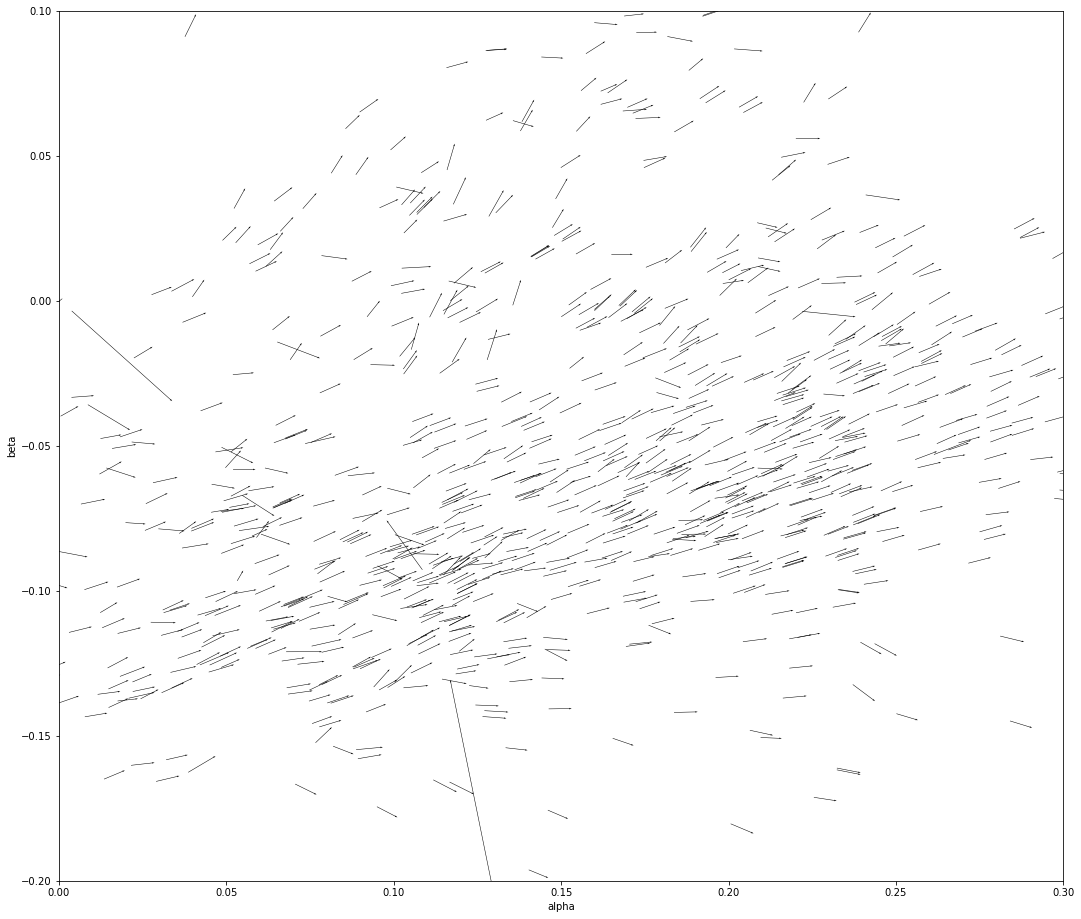

In [433]:
fig=plt.figure(figsize=(18, 16))
plt.quiver(cxs, cys, mxs, mys, scale=0.2, width=0.0005)
plt.xlim(-0.0, 0.3)
plt.ylim(-0.2, 0.1)
plt.xlabel('alpha')
plt.ylabel('beta')
plt.savefig('quiver.pdf')


Rotate to ecliptic coordinates, just to make the plots and explanations clearer.

Fit for transverse components of velocity, given radial distance function.

Given position and velocity vectors, take a Kepler step (or do a full n-body integration) to the reference time.

For individual detections, solve for the radial motion only.

In [350]:
arr = np.loadtxt('itf_new_1_line_2458016.5_pm75.0.sel', usecols=(1, 2, 3, 4))

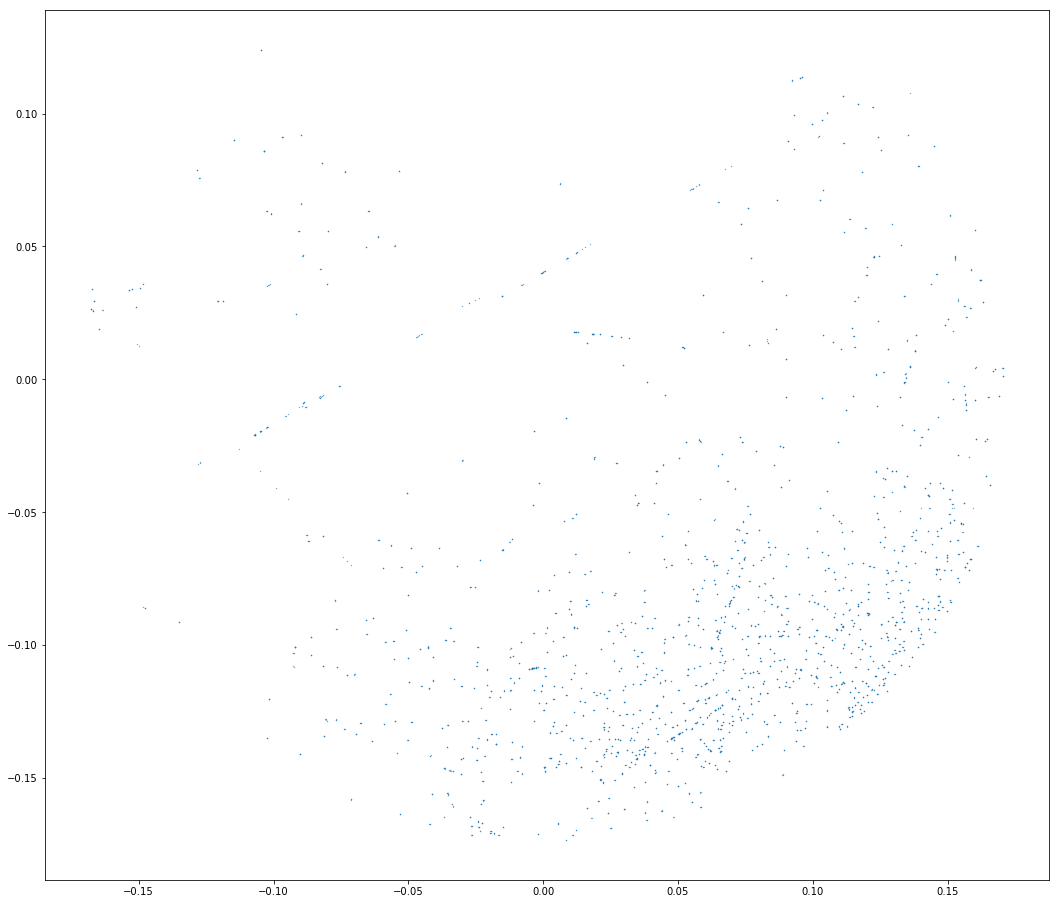

In [351]:
fig=plt.figure(figsize=(18, 16))
plt.scatter(arr[:,1], arr[:,2], s=0.3, marker='.')

In [338]:
arr[:,0].max()

2458028.8951030001

In [323]:
arr

array([[  2.45801609e+06,  -6.96082000e-02,  -1.55117000e-02,
          9.97453800e-01],
       [  2.45801610e+06,  -6.95756000e-02,  -1.55096000e-02,
          9.97456100e-01],
       [  2.45801610e+06,  -6.95418000e-02,  -1.55072000e-02,
          9.97458500e-01],
       ..., 
       [  2.45802880e+06,  -7.13558000e-02,   4.88970000e-02,
          9.96251700e-01],
       [  2.45802882e+06,  -7.12898000e-02,   4.89261000e-02,
          9.96255000e-01],
       [  2.45802884e+06,  -7.12238000e-02,   4.89598000e-02,
          9.96258100e-01]])

Next, I need to transform to the tangent plane defined by the reference direction.
Then I can fit for the x-y motion of tracklets in that tangent plane.

In [297]:
def xyz_to_proj_matrix(r_ref):
    x_ref, y_ref, z_ref = r_ref
    r = np.sqrt(x_ref*x_ref + y_ref*y_ref + z_ref*z_ref)
    lon0 = np.arctan2(y_ref, x_ref)
    lat0 = np.arcsin(z_ref/r)
    slon0 = np.sin(lon0)
    clon0 = np.cos(lon0)
    slat0 = np.sin(lat0)
    clat0 = np.cos(lat0)

    mat = np.array([[-slon0, clon0, 0], 
                    [-clon0*slat0, -slon0*slat0, clat0], 
                    [clon0*clat0, slon0*clat0, slat0 ]])
    
    return mat


In [302]:
np.dot(xyz_to_proj_matrix(np.array([1, 0, 0])), np.array([0, 0, 1]))

array([ 0.,  1.,  0.])